In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import cv2
import os
import seaborn as sns
import warnings
import pickle

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-10-25 21:21:44.094464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761427304.284829      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761427304.341068      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_skin = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma', 
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 
    'akiec': 4, 'vasc': 5, 'df': 6
}

df_skin['lesion_type'] = df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

In [3]:
df_features = df_skin.copy()

missing_age = df_skin['age'].isnull().sum()
zero_age = (df_skin['age'] == 0).sum()

if missing_age > 0 or zero_age > 0:
    mean_ages_per_class = df_features[df_features['age'] > 0].groupby('dx')['age'].mean().round().astype(int)
    df_features['age'] = df_features.apply(
        lambda row: mean_ages_per_class[row['dx']] if pd.isna(row['age']) or row['age'] == 0 else row['age'],
        axis=1
    )

unknown_sex_count = (df_features['sex'] == 'unknown').sum()
if unknown_sex_count > 0:
    majority_sex_per_class = df_features[df_features['sex'] != 'unknown'].groupby('dx')['sex'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown')
    df_features['sex'] = df_features.apply(
        lambda row: majority_sex_per_class[row['dx']] if row['sex'] == 'unknown' else row['sex'],
        axis=1
    )

unknown_localization_count = (df_features['localization'] == 'unknown').sum()
if unknown_localization_count > 0:
    majority_localization_per_class = df_features[df_features['localization'] != 'unknown'].groupby('dx')['localization'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown')
    overall_majority = df_features[df_features['localization'] != 'unknown']['localization'].mode().iloc[0] if not df_features[df_features['localization'] != 'unknown']['localization'].mode().empty else 'trunk'
    df_features['localization'] = df_features.apply(
        lambda row: (majority_localization_per_class.get(row['dx'], overall_majority) 
                    if majority_localization_per_class.get(row['dx'], overall_majority) != 'unknown' 
                    else overall_majority) if row['localization'] == 'unknown' else row['localization'],
        axis=1
    )

sex_encoded = pd.get_dummies(df_features['sex'], prefix='sex')
df_features = pd.concat([df_features, sex_encoded], axis=1)

localization_encoded = pd.get_dummies(df_features['localization'], prefix='localization')
df_features = pd.concat([df_features, localization_encoded], axis=1)

sun_exposure_mapping = {
    'face': 1.0, 'neck': 0.9, 'ear': 0.9, 'scalp': 0.8, 'hand': 0.8,
    'upper extremity': 0.7, 'lower extremity': 0.6, 'chest': 0.5,
    'back': 0.4, 'foot': 0.4, 'trunk': 0.3, 'abdomen': 0.2,
    'acral': 0.3, 'genital': 0.01
}

df_features['sun_exposure_score'] = df_features['localization'].map(sun_exposure_mapping)
df_features['age_exposure_interaction'] = df_features['age'] * df_features['sun_exposure_score']

tabular_features = df_features[['lesion_id', 'image_id', 'lesion_ID'] + 
                              [col for col in df_features.columns if col.startswith(('sex_', 'localization_'))] +
                              ['age', 'sun_exposure_score', 'age_exposure_interaction']].copy()

In [4]:
def produce_augmented_images(img, target_class):
    if target_class == 0:
        return [img]
    
    augmented = [
        cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),
        cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE), 
        cv2.rotate(img, cv2.ROTATE_180),
        cv2.flip(img, 0),
        cv2.flip(img, 1)
    ]
    return [img] + augmented

def load_and_preprocess_images():
    x, y = [], []
    image_dirs = ['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/', 
                  '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/']
    
    for img_dir in image_dirs:
        if not os.path.exists(img_dir):
            continue
            
        file_list = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
        for filename in file_list:
            img_path = os.path.join(img_dir, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            img_resized = cv2.resize(img, (100, 100))
            image_id = filename.replace('.jpg', '')
            lesion_data = df_skin[df_skin['image_id'] == image_id]
            
            if len(lesion_data) == 0:
                continue
                
            lesion_id = lesion_data['lesion_ID'].iloc[0]
            augmented_imgs = produce_augmented_images(img_resized, lesion_id)
            
            for aug_img in augmented_imgs:
                x.append(aug_img)
                y.append(lesion_id)
    
    return np.array(x), np.array(y)

In [5]:
augmented_data_paths = [
    '/kaggle/working/X_augmented.npy',
    '/kaggle/working/y_augmented.npy', 
    '/kaggle/working/y_categorical_augmented.npy'
]

if all(os.path.exists(path) for path in augmented_data_paths):
    X = np.load('/kaggle/working/X_augmented.npy')
    y = np.load('/kaggle/working/y_augmented.npy')
    y_categorical = np.load('/kaggle/working/y_categorical_augmented.npy')
else:
    X, y = load_and_preprocess_images()
    y_categorical = to_categorical(y, num_classes=7)
    np.save('/kaggle/working/X_augmented.npy', X)
    np.save('/kaggle/working/y_augmented.npy', y)
    np.save('/kaggle/working/y_categorical_augmented.npy', y_categorical)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train_labels), 
    y=y_train_labels
)
class_weight_dict = dict(zip(np.unique(y_train_labels), class_weights))

In [7]:
def create_cnn_model(input_shape=(100, 100, 3), num_classes=7):
    model = Sequential([
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        
        Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        
        Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same'),
        BatchNormalization(),
        
        Conv2D(384, (1, 1), strides=(1, 1), activation='relu', padding='same'),
        BatchNormalization(),
        
        Conv2D(256, (1, 1), strides=(1, 1), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'), 
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

model = create_cnn_model()
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1761427465.239684      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
BATCH_SIZE = 32
EPOCHS = 50

datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)

callbacks = [
    ModelCheckpoint(
        '/kaggle/working/best_image_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=0
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=0
    )
]

In [9]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=0
)

print("Training Progress:")
for epoch in range(len(history.history['loss'])):
    train_loss = history.history['loss'][epoch]
    train_acc = history.history['accuracy'][epoch]
    val_loss = history.history['val_loss'][epoch]
    val_acc = history.history['val_accuracy'][epoch]
    print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

I0000 00:00:1761427474.698668      59 service.cc:148] XLA service 0x7a590c018ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761427474.699423      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761427475.308268      59 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761427480.836974      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Progress:
Epoch 1/50 - loss: 1.7244 - acc: 0.4036 - val_loss: 2.0380 - val_acc: 0.3032
Epoch 2/50 - loss: 1.2669 - acc: 0.4935 - val_loss: 3.7816 - val_acc: 0.2923
Epoch 3/50 - loss: 1.1845 - acc: 0.5276 - val_loss: 1.1652 - val_acc: 0.5573
Epoch 4/50 - loss: 1.0942 - acc: 0.5427 - val_loss: 1.8485 - val_acc: 0.3394
Epoch 5/50 - loss: 1.0721 - acc: 0.5630 - val_loss: 1.1300 - val_acc: 0.5562
Epoch 6/50 - loss: 1.0032 - acc: 0.5739 - val_loss: 2.1757 - val_acc: 0.4052
Epoch 7/50 - loss: 0.9509 - acc: 0.5949 - val_loss: 1.5476 - val_acc: 0.4694
Epoch 8/50 - loss: 0.9347 - acc: 0.5935 - val_loss: 1.1780 - val_acc: 0.5389
Epoch 9/50 - loss: 0.8633 - acc: 0.6160 - val_loss: 1.7268 - val_acc: 0.3732
Epoch 10/50 - loss: 0.8435 - acc: 0.6192 - val_loss: 1.1491 - val_acc: 0.5594
Epoch 11/50 - loss: 0.7412 - acc: 0.6519 - val_loss: 0.9223 - val_acc: 0.6418
Epoch 12/50 - loss: 0.6965 - acc: 0.6624 - val_loss: 1.2265 - val_acc: 0.5507
Epoch 13/50 - loss: 0.6607 - acc: 0.6736 - val_loss: 1

In [10]:
best_model = tf.keras.models.load_model('/kaggle/working/best_image_model.keras')
y_pred = best_model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

test_accuracy = accuracy_score(y_true_classes, y_pred_classes)
balanced_acc = balanced_accuracy_score(y_true_classes, y_pred_classes)
macro_f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
macro_precision = precision_score(y_true_classes, y_pred_classes, average='macro')
macro_recall = recall_score(y_true_classes, y_pred_classes, average='macro')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

Test Accuracy: 0.8515
Balanced Accuracy: 0.9074
Macro F1: 0.8771
Macro Precision: 0.8538
Macro Recall: 0.9074


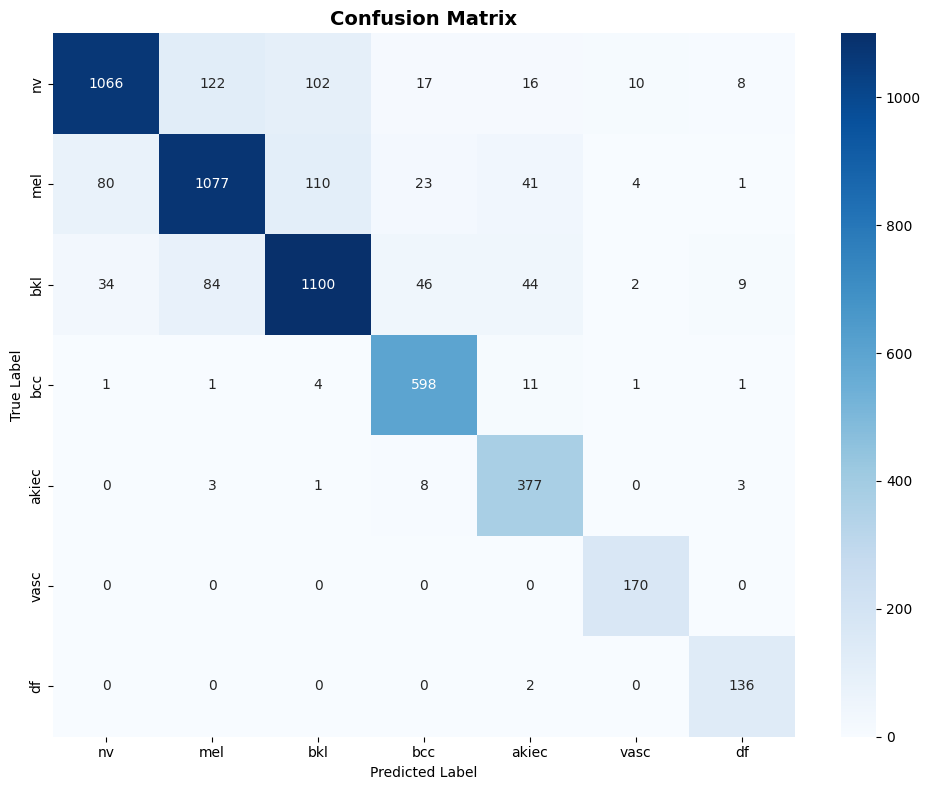

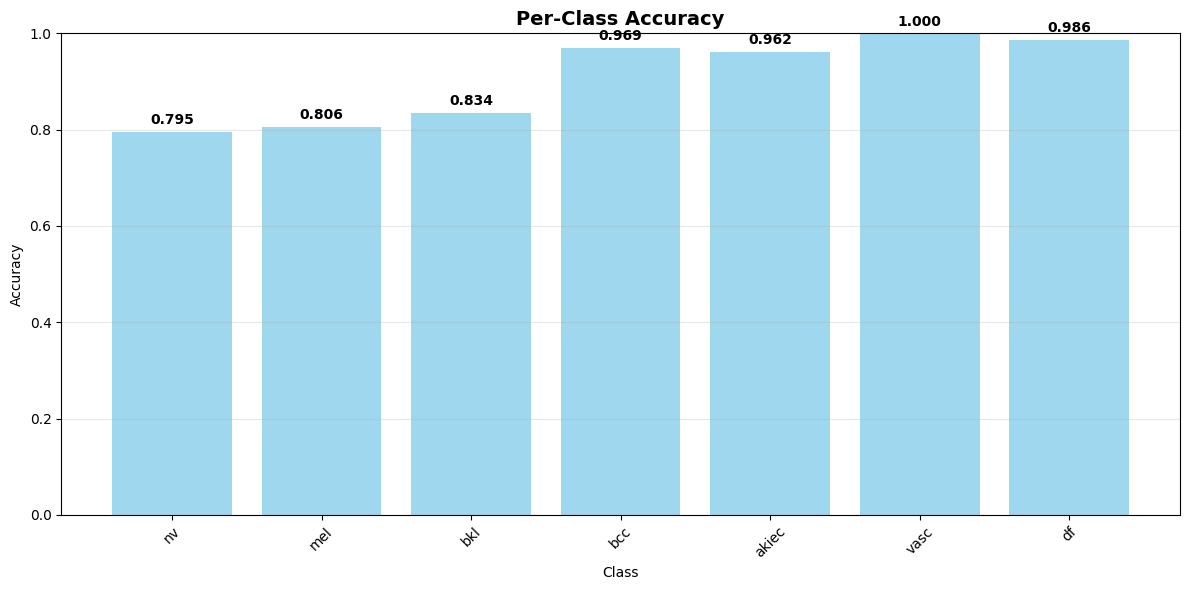

In [11]:
lesion_names_short = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=lesion_names_short,
            yticklabels=lesion_names_short)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

class_accuracies = []
for i in range(7):
    class_mask = y_true_classes == i
    if np.sum(class_mask) > 0:
        class_acc = np.mean(y_pred_classes[class_mask] == y_true_classes[class_mask])
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0.0)

plt.figure(figsize=(12, 6))
bars = plt.bar(range(7), class_accuracies, color='skyblue', alpha=0.8)
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(range(7), lesion_names_short, rotation=45)
plt.ylim(0, 1)

for i, (bar, acc) in enumerate(zip(bars, class_accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
if hasattr(best_model, 'input') and best_model.input is not None:
    model_input = best_model.input
else:
    model_input = best_model.layers[0].input

feature_layer = None
for layer in best_model.layers:
    if isinstance(layer, MaxPool2D):
        feature_layer = layer
        if 'max_pooling2d_2' in layer.name:
            break

if feature_layer is None or 'max_pooling2d_2' not in feature_layer.name:
    maxpool_layers = [layer for layer in best_model.layers if isinstance(layer, MaxPool2D)]
    if len(maxpool_layers) >= 2:
        feature_layer = maxpool_layers[1]
    else:
        feature_layer = maxpool_layers[0]

image_feature_extractor = Model(
    inputs=model_input,
    outputs=feature_layer.output,
    name='ImageFeatureExtractor'
)
image_feature_extractor.save('/kaggle/working/image_feature_extractor.keras')

np.save('/kaggle/working/X_train.npy', X_train)
np.save('/kaggle/working/X_test.npy', X_test)
np.save('/kaggle/working/y_train.npy', y_train)
np.save('/kaggle/working/y_test.npy', y_test)

with open('/kaggle/working/class_weight_dict.pkl', 'wb') as f:
    pickle.dump(class_weight_dict, f)

df_skin.to_csv('/kaggle/working/metadata.csv', index=False)

exp1_results = {
    'test_accuracy': float(test_accuracy),
    'balanced_accuracy': float(balanced_acc),
    'confusion_matrix': cm,
    'training_history': {
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'acc': history.history['accuracy'],
        'val_acc': history.history['val_accuracy']
    },
    'predictions': y_pred_classes
}

with open('/kaggle/working/exp1_results.pkl', 'wb') as f:
    pickle.dump(exp1_results, f)